Author: Padina Nasiri Toussi

This is my first attempt at creating/training a Computer Vision model for the 2025 CodeFest challenge #1
It aims to correctly classify garbage images for the purpose of recycling

The model is trained on the data found here:
https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2?resource=download

Note: This is the public version. The public version would not show my kaggle username and API

Version 1.2: THIS IS AN INCOMPLETE VERSION OF MY PROGRAM. IT IS ONLY SAVED FOR THE SAKE OF PRESERVATION AND REFERENCE. PLEASE REFERENCE LATER ITERATIONS FOR MORE UP TO DATE RESULTS.

The model works and can be trained successfully, but there is an issue in trying to use data gathered through callbacks during training, to later plot certain metrics.

# Step 0: Some Useful Libraries

In [ ]:
# importing some libraries which we will probably use later
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image

# ensure any matplotlib graphs will be displayed inline
%matplotlib inline

import tensorflow as tf
from numpy.random import RandomState
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Step 1: Downloading Data

In [ ]:
# First step is to download the dataset directly from Kaggle
# Step 1.1 - add your kaggle info
import os
os.environ['KAGGLE_USERNAME'] = ""  # todo: add your username here
os.environ['KAGGLE_KEY'] = "" # todo: add your key here

In [ ]:
# Step 1.2: Install the Kaggle API client
!pip install kaggle

In [ ]:
# Step 1.3: Download garbage dataset
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 99% 740M/744M [00:08<00:00, 56.0MB/s]
100% 744M/744M [00:08<00:00, 89.9MB/s]


In [ ]:
# Step 1.4: Unzip the downloaded dataset
!unzip garbage-classification-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/pa

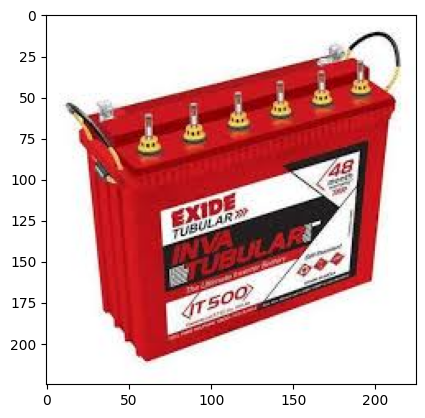

In [ ]:
# Loading a sample image
sample_image = Image.open(os.path.join('/content/garbage-dataset/battery/battery_101.jpg'))  # Load the first image
plt.imshow(sample_image)
plt.show()

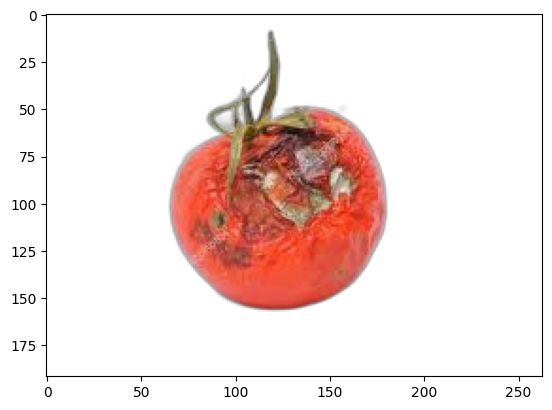

In [ ]:
my_path = '/content/garbage-dataset/biological/biological_10.jpg'
sample_image = Image.open(os.path.join(my_path))  # Load the first image
plt.imshow(sample_image)  # todo for later

# Step 2: Dealing with the DATA

In [ ]:
# Step 2.1: Some useful variables

# The path for data directory on Collab
image_dir = '/content/garbage-dataset'

In [ ]:
# resizing variables - this ensures that everything is of the same square shaped size
# A glimpsing look at the data images shows that there are many different shapes and sizes
# note for later: we could also potentially include some rotated examples in the dataset? - potentially useful in real life scenario
img_width = 250
img_height = 250

In [ ]:
# Step 2.2: Loading the resized shuffled dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_dir,
    image_size=(img_width, img_height),  # Resize images
    batch_size=32,
    shuffle=True,
    seed=25,  # Setting the random seed for reproducibility
    label_mode='int'
)

Found 19762 files belonging to 10 classes.


In [ ]:
full_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Printing the number of batches in the dataset
print(f"Total number of batches: {len(full_dataset)}")

Total number of batches: 618


In [ ]:
# Step 2.3: Saving the categories and their corresponding integers
category_list = full_dataset.class_names  # saving categories as a list
print(category_list)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [ ]:
# saving categories as a dictionary
category_dict = {i: category for i, category in enumerate(full_dataset.class_names)}
print(category_dict)

{0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}


In [ ]:
# Note: Any further data cleaning/modification, such as adding rotated images
# should be either done here, or after the train test split

# Step 3: Train Test Split
Splitting the data into train, validation, and test groups
Train = 70% of whole data
of the remainder 30%:
- Val: 50%
- Test: 50%

Therefor the split ratio is:
70 : 15 : 15

In [ ]:
# # OLD VERSION: (kept for reference)
# # Convert the full dataset into arrays of images and labels
# image_list = []
# label_list = []

# for image, label in full_dataset:
#     image_list.append(image.numpy())
#     label_list.append(label.numpy())

# # Convert lists to numpy arrays
# image_array = np.concatenate(image_list, axis=0)
# label_array = np.concatenate(label_list, axis=0)

In [ ]:
# # Also old version - Ran out of RAM on step 3.1 (kept for reference)
# # Step 3.1: Convert the dataset to numpy arrays
# image_arrays = np.concatenate([x[0].numpy() for x in full_dataset], axis=0)  # Getting image data
# labels = np.concatenate([x[1].numpy() for x in full_dataset], axis=0)  # Getting labels

# # Step 3.2: Train Val Test split

# # split 1 - train data
# X_train, X_temptest, y_train, y_temptest = train_test_split(image_arrays, labels, test_size=0.3, random_state=25)

# # split 2 - validation and test data
# X_val, X_test, y_val, y_test = train_test_split(X_temptest, y_temptest, test_size=0.5, random_state=25)

midway note: ignore this version of the code, I'm now doing the train val test split in another way

In [ ]:
# # Step 3.1: Train Validation Split (Split 1)
# # note that after running this code, full_dataset is basically just the training data

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     image_dir,
#     image_size= (img_width, img_height),
#     batch_size= 32,
#     validation_split=0.3,
#     subset='validation',  # 'validation' subset (as opposed to 'training')
#     seed= 25  # Seed for reproducibility
# )

In [ ]:
# # Step 3.2: Renaming full_dataset to train_dataset for naming simplicity

# # Saving full_dataset into train_dataset
# train_dataset = full_dataset

# # Deleting the original full_dataset to free up memory
# del full_dataset

In [ ]:
# # We can check if full_dataset is deleted by trying to print the variable (it should raise an error)
# try:
#     print(full_dataset)
# except NameError:
#     print("full_dataset has been deleted successfully.")

In [ ]:
# Step 3.3: Validation Test Split (Split 2)

# ...

midway note/aside: This is where the actual Step 3 code starts

In [ ]:
# Step 3.1: defining some values

# Dataset size
dataset_size = len(full_dataset)
print("Dataset Size: " + str(dataset_size))

# Split ratios
train_ratio = 0.7  # 70% training
val_ratio = 0.15  # 15% validation
test_ratio = 0.15  # 15% testing

# Split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

Dataset Size: 618


In [ ]:
# Step 3.2: The actual splitting

# Split dataset
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size).take(val_size)
test_dataset = full_dataset.skip(train_size + val_size)

# Print dataset sizes
print(f"Train size: {len(train_dataset)} batches")
print(f"Validation size: {len(val_dataset)} batches")
print(f"Test size: {len(test_dataset)} batches")

Train size: 432 batches
Validation size: 92 batches
Test size: 94 batches


# Step 4: Creating the Model
For this version, let's create a sequencial model from scratch

We will be using Depthwise Separable Convolutions to create more efficient and resource friendly architectures

In [ ]:
# Step 4.1: Create Model !!!
model = models.Sequential()


# Step 4.2: Add a bunch of layers

# Note: Instead of just Conv2D convolutional layers, I am using Conv2D and DepthwiseConv2D
# which splits the convolution operation into two parts of filtering and combining
# This greatly reduces both the number of parameters and the computational cost.
# Batch normalization also helps to speed up training and improves model stability
# The Dense layer helps the model learn abstractions, but it is not TOO big to increase efficiency/reduce complexity
# I am using relatively small number of filters (16, 32, 64) as opposed to more (such as 512) to reduce complexity

# Input layer: Expecting images of shape (img_width, img_height, 3)
model.add(layers.InputLayer(input_shape=(img_width, img_height, 3)))

# Depthwise Separable Convolutions (lightweight) - this is similar to famous efficient models like MobileNet
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flattenning the feature maps
model.add(layers.Flatten())

# Adding a dense layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  # Adding a dropout for regularization

# New output layer
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Step 4.3: Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 250, 250, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_3 (DepthwiseConv2D) │ (None, 250, 250, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 250, 250, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 125, 125, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 250000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      32,000,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,002,090 (122.08 MB)

 Trainable params: 32,002,058 (122.08 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
# Step 4.4: Compiling the model
# Old
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# New
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# Step 5: Training the Model

In [ ]:
# Step 5.1: Defining the custom callback class AccuracyCallback

# This class would be later used to capture and plot both batch and epoch accuracies
class AccuracyCallback(tf.keras.callbacks.Callback):
  def __init__(self, graph_epoch_accuracies, graph_batch_accuracies):
    # note graph_epoch_accuracies and graph_batch_accuracies are bools
    self.graph_epoch_accuracies = graph_epoch_accuracies
    self.graph_batch_accuracies = graph_batch_accuracies

    # Some lists to keep track of prediction accuracies over time
    self.train_batch_accuracies = []
    self.val_batch_accuracies = []
    self.train_accuracies = []
    self.val_accuracies = []

  # Capture accuracy per epoch
  def on_epoch_end(self, epoch, logs=None):
    if self.graph_epoch_accuracies:
      self.train_accuracies.append(logs.get('accuracy'))
      self.val_accuracies.append(logs.get('val_accuracy'))

  # Capture accuracy per batch
  def on_batch_end(self, batch, logs=None):
    if self.graph_batch_accuracies:
      self.train_batch_accuracies.append(logs.get('accuracy'))
      self.val_batch_accuracies.append(logs.get('val_accuracy'))

In [ ]:
# Step 5.2: Defining the train_in_batches function
# Training in small batches ensures we don't run out of RAM space
# Can keep track of accuracy over epochs
# Can plot accuracy over batches during each epoch

# This is the main function for training in batches
# note since we've already defined batches in full_dataset, no need to do so here
def train_in_batches(model, train_dataset, val_dataset, num_epochs=10, graph_epoch_accuracies=True, graph_batch_accuracies=True):
  # If relevant, using the accuracy callback with the relevant plotting flags
  # callbacks = []
  # if (graph_epoch_accuracies or graph_batch_accuracies):
  #   accuracy_callback = AccuracyCallback(graph_epoch_accuracies, graph_batch_accuracies)
  #   callbacks.append(accuracy_callback)
  accuracy_callback = AccuracyCallback(graph_epoch_accuracies, graph_batch_accuracies)

  # # Key Section: Train the Model! (old version)
  # history = model.fit(
  #   train_dataset.batch(batch_size),
  #   validation_data=val_dataset.batch(batch_size),
  #   epochs=num_epochs,
  #   callbacks=callbacks
  # )

  print("everything ok so far")

  # Key Section: Train the Model! (new version)
  history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    # callbacks=callbacks
    callbacks = [accuracy_callback]
  )

  print("everything ok so far")

  # If enabled: Plotting accuracy graphs for epoch and batch accuracies
  if graph_epoch_accuracies:
    # Plotting for batch-wise accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), accuracy_callback.train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), accuracy_callback.val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy per Epoch")
    plt.show()

  if graph_batch_accuracies:
    # Plotting for batch-wise accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy_callback.train_batch_accuracies, label="Training Batch Accuracy")
    plt.plot(accuracy_callback.val_batch_accuracies, label="Validation Batch Accuracy")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy per Batch")
    plt.show()

  # Return the accuracies after training (both epoch and batch)
  # if(graph_epoch_accuracies or graph_batch_accuracies):
  #   return accuracy_callback.train_accuracies, accuracy_callback.val_accuracies, accuracy_callback.train_batch_accuracies, accuracy_callback.val_batch_accuracies
  # else:
  #   return [], [], [], []

  return history


In [ ]:
# Step 5.3: Call train_in_batches() to actually train the model
# For now, let's train the model for a single epoch
# Now having trouble with the plotting part (especially over batches), but other than that should be fine

num_epochs = 2

graph_epoch_accuracies = True
graph_batch_accuracies = True

history = train_in_batches(model, train_dataset, val_dataset, num_epochs, graph_epoch_accuracies, graph_batch_accuracies)


everything ok so far
Epoch 1/2
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5712 - loss: 1.3091

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_9499]

# Step 6: Tests and Validations

# Step 7: Saving the Model
Saving and exporting the model

# Step 8: Useful Functions
Function(s) used to run saved model on individual or bulk data, and return useful output - identified category, confidence level (eg. low confidence level could mean don't risk categorizing as recyclable), displaying top likely categories, category precentages, etc.

This section can also be done in, or copied into, a separate collab page to use the model without training